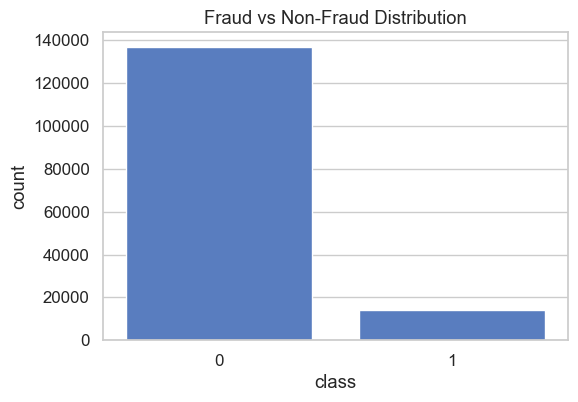

C:\Users\hp\AppData\Local\Temp\ipykernel_24768\2786127812.py:73: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='hour_of_day', y='class', data=fraud_df, ci=None)


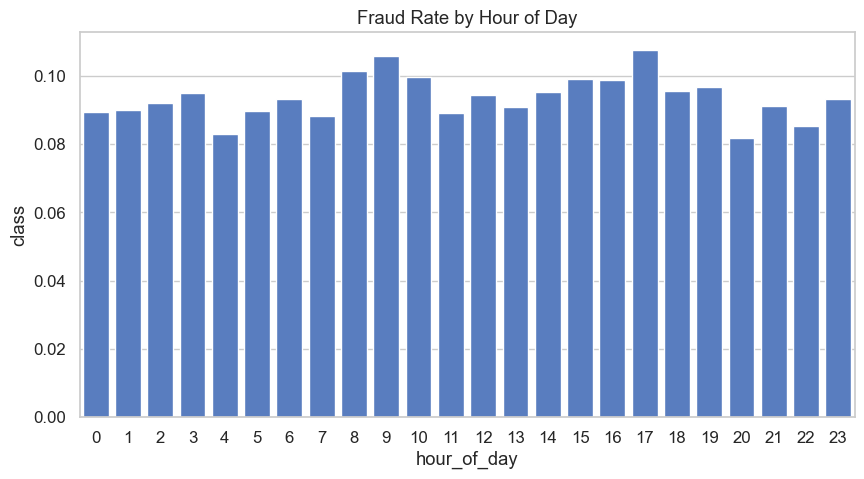

C:\Users\hp\AppData\Local\Temp\ipykernel_24768\2786127812.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='class', data=fraud_df, ci=None)


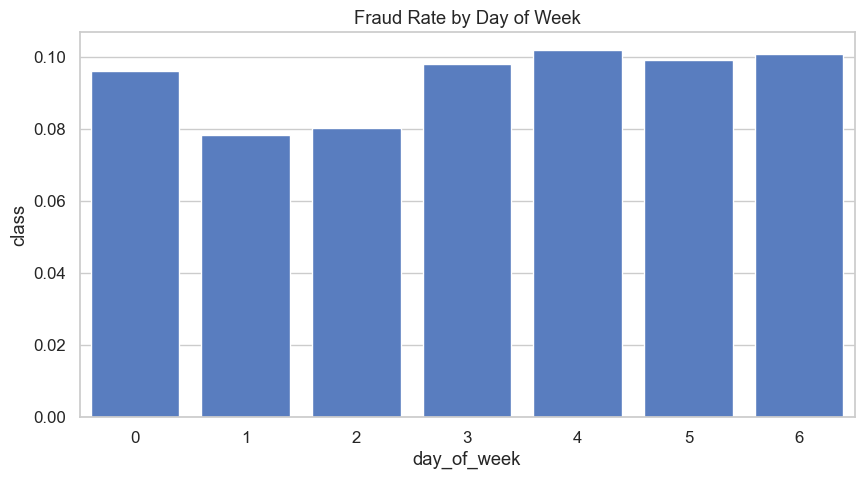

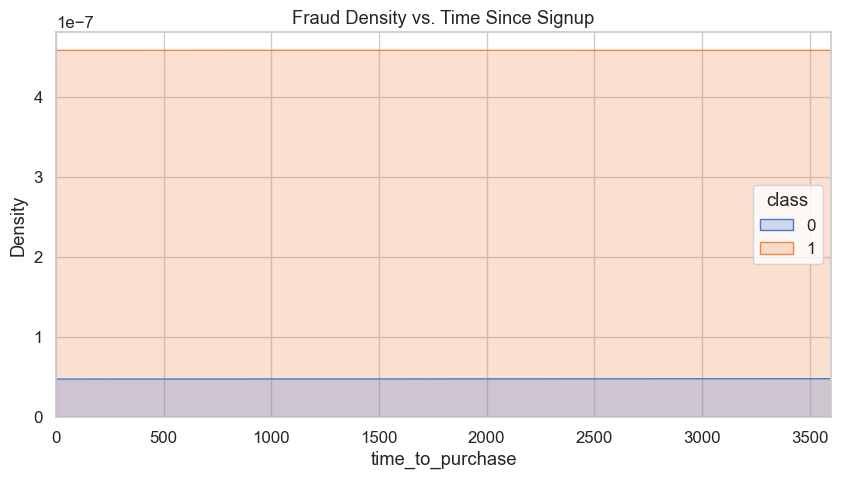

EDA & geolocation integration complete.


In [1]:
# -----------------------------
# 1️⃣ Libraries
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# -----------------------------
# 2️⃣ Load Data
# -----------------------------
fraud_df = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_df = pd.read_csv("../data/raw/IpAddress_to_Country.csv")

# -----------------------------
# 3️⃣ Data Cleaning
# -----------------------------
# Remove duplicates
fraud_df.drop_duplicates(inplace=True)

# Correct types
fraud_df['ip_address'] = fraud_df['ip_address'].astype(float)
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# -----------------------------
# 4️⃣ Geolocation Integration
# -----------------------------
fraud_df.sort_values('ip_address', inplace=True)
ip_df.sort_values('lower_bound_ip_address', inplace=True)

# Merge
fraud_df = pd.merge_asof(
    fraud_df, ip_df, left_on='ip_address', right_on='lower_bound_ip_address'
)

# Robust bound check
fraud_df['country'] = np.where(
    (fraud_df['ip_address'] <= fraud_df['upper_bound_ip_address']),
    fraud_df['country'], 'Unknown'
)
fraud_df['country'] = fraud_df['country'].fillna('Unknown')

# -----------------------------
# 5️⃣ Feature Engineering
# -----------------------------
# Time-based features
fraud_df['time_to_purchase'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['time_since_signup'] = fraud_df['time_to_purchase']  # Alias for clarity

# Velocity features
fraud_df['device_usage_count'] = fraud_df.groupby('device_id')['device_id'].transform('count')
fraud_df['ip_usage_count'] = fraud_df.groupby('ip_address')['ip_address'].transform('count')

# Country risk score
country_risk = fraud_df.groupby('country')['class'].mean()
fraud_df['country_risk_score'] = fraud_df['country'].map(country_risk)

# -----------------------------
# 6️⃣ EDA: Class Distribution
# -----------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=fraud_df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

# Fraud rate by hour
plt.figure(figsize=(10,5))
sns.barplot(x='hour_of_day', y='class', data=fraud_df, ci=None)
plt.title("Fraud Rate by Hour of Day")
plt.show()

# Fraud rate by day of week
plt.figure(figsize=(10,5))
sns.barplot(x='day_of_week', y='class', data=fraud_df, ci=None)
plt.title("Fraud Rate by Day of Week")
plt.show()

# Time-to-purchase distribution (instant fraud)
plt.figure(figsize=(10,5))
sns.kdeplot(data=fraud_df, x='time_to_purchase', hue='class', common_norm=False, fill=True)
plt.title("Fraud Density vs. Time Since Signup")
plt.xlim(0, 3600)  # Focus on first hour
plt.show()

# -----------------------------
# 7️⃣ Save Processed Data
# -----------------------------
fraud_df.to_csv("../data/processed/fraud_geo_processed.csv", index=False)
print("EDA & geolocation integration complete.")
